In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import warnings
import glob
import gzip
from collections import Counter
import os
import seaborn as sns
from pybedtools import BedTool
from Bio import bgzf

In [2]:
%matplotlib inline
# figure size & color
matplotlib.rcParams['figure.dpi'] = 100 # 150 dpi resolution
matplotlib.rcParams['image.cmap'] = 'Spectral_r' # preferred color map
matplotlib.rcParams['figure.figsize'] = [8, 8] # Square


# no bounding boxes or axis:
matplotlib.rcParams['axes.spines.bottom'] = "on"
matplotlib.rcParams['axes.spines.top'] = "off"
matplotlib.rcParams['axes.spines.left'] = "on"
matplotlib.rcParams['axes.spines.right'] = "off"
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)
matplotlib.rcParams['axes.linewidth'] = 2 #set the value globally

In [4]:
fig_dir = '/fh/fast/henikoff_s/user/jgreene/projects/sciCnT/data/Figures/'

In [5]:
def barnyard(bedpaths, nreads):
    """
    Takes 2 bed files from crossmapped species and returns a dataframe of counts
    
    args: 
        bedpaths (list): list of bed paths
        nreads (int): number of reads to pass "cutoff"
        
    Returns:
        df (pd.DataFrame): shape M(single cell barcodes) x N (species experiment)
        
    """
    
    scdict = dict()
    N = len(bedpaths)
    for k, bed in enumerate(bedpaths):
        stream = bgzf.open(bed, 'r')
        for rd in stream:     
            # get list of structure [chr, start, stop, barcode, pcrdup counts]
            rd = rd.strip().split("\t")
            barc = rd[3]

            try:
                scdict[barc][k] += 1
            # init barcode if it doesn't exist
            except KeyError:
                scdict[barc] = np.zeros(N)
                scdict[barc][k] += 1
                
                
    # THIS IS SUPER INEFFICIENT CODE AND WON'T SCALE. VSTACK = SLOW
    arr = np.vstack([scdict[barc] for barc in scdict])
    df = pd.DataFrame(arr, index=list(scdict.keys()), columns=['K27', 'K4'])
    df['Reads'] = df['K27'] + df['K4']
    df = df[df['Reads'] > nreads]
    df.sort_values(by=['Reads'], ascending=False, inplace = True)
    df['cell'] = np.arange(df.shape[0])
    
    #label assignments
    # df['ratio'] = df['Hg38'] / df['Reads']
    # df.loc[(df['ratio'] >= .9),'Assignment'] = 'human'
    # df.loc[((df['ratio'] < .9) & (df['ratio'] > .1)),'Assignment'] = 'collision'
    # df.loc[(df['ratio'] <= .1),'Assignment'] = 'mouse'
    
    #format
    #df.sort_values(by=['Reads'], ascending=False, inplace = True)
    #df['cell'] = np.arange(df.shape[0])
    
    return df



In [6]:
#path to beds
bed_dir = '/fh/fast/henikoff_s/user/jgreene/projects/sciCnT/data/DJ_Hs_PBMC_220527_79x79/bgzip_beds/'

In [7]:
#make barnyard df per dispense
PBMC_ALLSEQ_220527 = barnyard([
    bed_dir + 'DJ_Hs_PBMC_K27me3_ALLSEQ_220527.fragments.tsv.gz', 
    bed_dir + 'DJ_Hs_PBMC_K4me123_ALLSEQ_220527.fragments.tsv.gz'], 
    nreads=100)

In [11]:
PBMC_ALLSEQ_220527

,K27,K4,Reads,cell
AGTAGATT_CCAGTTTA_TCCGCGAA_CAGGACGT,43508.0,0.0,43508.0,0
ATCACTCG_AGAGATCT_AGCGATAG_GTACTGAC,42160.0,0.0,42160.0,1
CGGCCAAT_TGTTCCTG_CGGCTATG_TATAGCCT,38638.0,0.0,38638.0,2
TACACCTC_GGTGAAGG_CGGCTATG_GTACTGAC,33657.0,0.0,33657.0,3
AGTAGATT_AGTCCGAG_AGCGATAG_TAATCTTA,31099.0,0.0,31099.0,4
...,...,...,...,...
GACTTAGT_TTTCTAGC_CGGCTATG_AGGCGAAG,101.0,0.0,101.0,28958
TAGGCATG_GGTTCAAT_CTGAAGCT_ATAGAGGC,101.0,0.0,101.0,28959
CGGTTCCC_CAGCAACG_TCCGGAGA_CCTATCCT,0.0,101.0,101.0,28960
AAACGGTC_TTTCTAGC_TCTCGCGC_CAGGACGT,101.0,0.0,101.0,28961


In [8]:
df = PBMC_ALLSEQ_220527
df.reset_index(inplace=True)
df[['i7', 'i5', 's7', 's5']] = df['index'].str.split('_', expand=True)
df

,index,K27,K4,Reads,cell,i7,i5,s7,s5
0,AGTAGATT_CCAGTTTA_TCCGCGAA_CAGGACGT,43508.0,0.0,43508.0,0,AGTAGATT,CCAGTTTA,TCCGCGAA,CAGGACGT
1,ATCACTCG_AGAGATCT_AGCGATAG_GTACTGAC,42160.0,0.0,42160.0,1,ATCACTCG,AGAGATCT,AGCGATAG,GTACTGAC
2,CGGCCAAT_TGTTCCTG_CGGCTATG_TATAGCCT,38638.0,0.0,38638.0,2,CGGCCAAT,TGTTCCTG,CGGCTATG,TATAGCCT
3,TACACCTC_GGTGAAGG_CGGCTATG_GTACTGAC,33657.0,0.0,33657.0,3,TACACCTC,GGTGAAGG,CGGCTATG,GTACTGAC
4,AGTAGATT_AGTCCGAG_AGCGATAG_TAATCTTA,31099.0,0.0,31099.0,4,AGTAGATT,AGTCCGAG,AGCGATAG,TAATCTTA
...,...,...,...,...,...,...,...,...,...
28958,GACTTAGT_TTTCTAGC_CGGCTATG_AGGCGAAG,101.0,0.0,101.0,28958,GACTTAGT,TTTCTAGC,CGGCTATG,AGGCGAAG
28959,TAGGCATG_GGTTCAAT_CTGAAGCT_ATAGAGGC,101.0,0.0,101.0,28959,TAGGCATG,GGTTCAAT,CTGAAGCT,ATAGAGGC
28960,CGGTTCCC_CAGCAACG_TCCGGAGA_CCTATCCT,0.0,101.0,101.0,28960,CGGTTCCC,CAGCAACG,TCCGGAGA,CCTATCCT
28961,AAACGGTC_TTTCTAGC_TCTCGCGC_CAGGACGT,101.0,0.0,101.0,28961,AAACGGTC,TTTCTAGC,TCTCGCGC,CAGGACGT


In [9]:
#drop cells with less than 500 reads
df_100 = df[df['Reads'] >= 100]

In [10]:
s5s7 = df_100.groupby(['s7','s5']).agg({'s5': ['count']}).reset_index()
s5s7.columns = ['s7','s5','count']

In [11]:
s5s7

,s7,s5,count
0,AGCGATAG,AGGCGAAG,332
1,AGCGATAG,ATAGAGGC,322
2,AGCGATAG,CAGGACGT,423
3,AGCGATAG,CCTATCCT,406
4,AGCGATAG,GTACTGAC,420
...,...,...,...
91,TCTCGCGC,CCTATCCT,316
92,TCTCGCGC,GTACTGAC,301
93,TCTCGCGC,TAATCTTA,318
94,TCTCGCGC,TATAGCCT,257


<AxesSubplot:xlabel='s5', ylabel='count'>

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


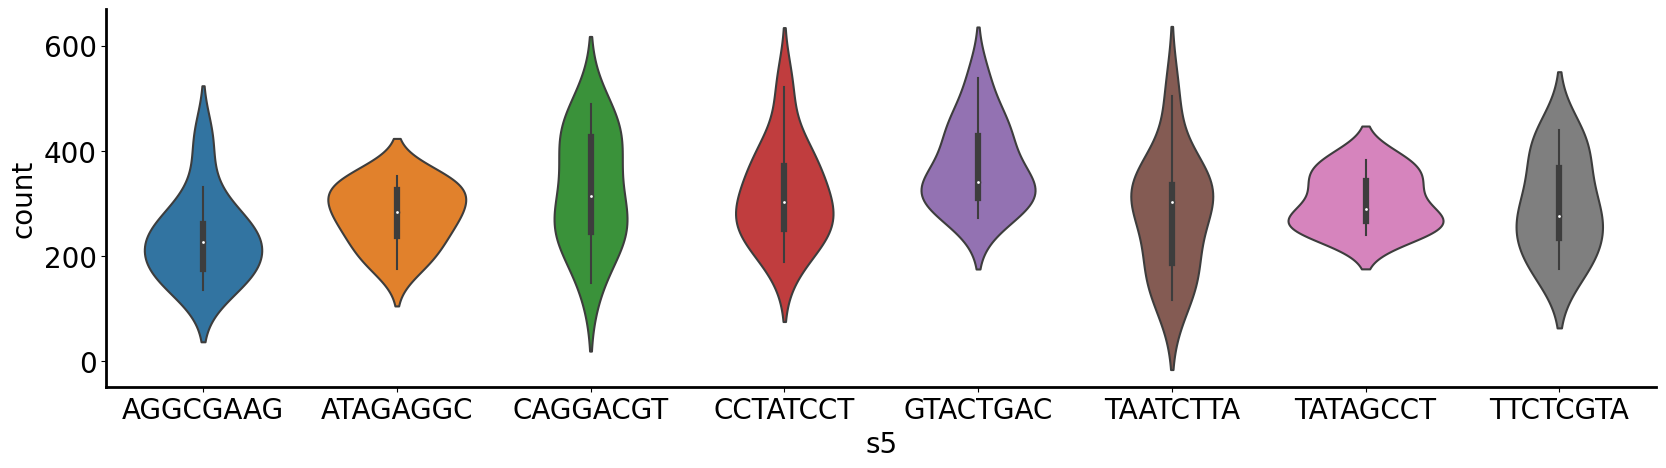

In [12]:
plt.figure(figsize=(20,5))
sns.violinplot(data=s5s7, x='s5', y='count')

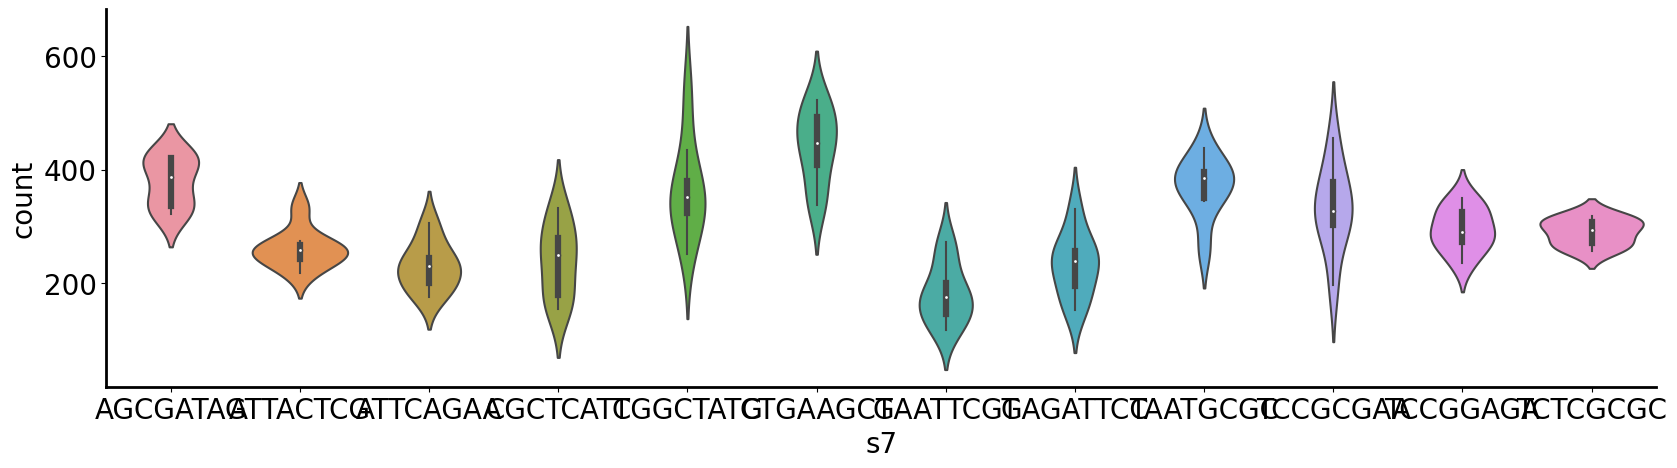

In [13]:
plt.figure(figsize=(20,5))
BY_All_0802_500_barcode_count_violinplot = sns.violinplot(data=s5s7, x='s7', y='count')

In [57]:
ann_dir = '/fh/fast/henikoff_s/user/jgreene/projects/sciCnT/data/barcodes/Tn5_ME_barcodes.csv'
Tn5_annotation_file = pd.read_csv(ann_dir)
Tn5_annotation_file = Tn5_annotation_file.iloc[:,[2,3,0,1]]
Tn5_annotation_file

,s5,s7,row,column
0,TATAGCCT,ATTACTCG,1,1
1,TATAGCCT,TCCGGAGA,1,2
2,TATAGCCT,CGCTCATT,1,3
3,TATAGCCT,GAGATTCC,1,4
4,TATAGCCT,ATTCAGAA,1,5
...,...,...,...,...
91,GTACTGAC,TAATGCGC,8,8
92,GTACTGAC,CGGCTATG,8,9
93,GTACTGAC,TCCGCGAA,8,10
94,GTACTGAC,TCTCGCGC,8,11


In [58]:
s5s7_lb = pd.merge(s5s7, Tn5_annotation_file, on=['s5','s7'])
s5s7_lb

,s7,s5,count,log_count,row,column
0,AGCGATAG,AGGCGAAG,332,2.521138,5,12
1,AGCGATAG,ATAGAGGC,322,2.507856,2,12
2,AGCGATAG,CAGGACGT,423,2.626340,7,12
3,AGCGATAG,CCTATCCT,406,2.608526,3,12
4,AGCGATAG,GTACTGAC,420,2.623249,8,12
...,...,...,...,...,...,...
91,TCTCGCGC,CCTATCCT,316,2.499687,3,11
92,TCTCGCGC,GTACTGAC,301,2.478566,8,11
93,TCTCGCGC,TAATCTTA,318,2.502427,6,11
94,TCTCGCGC,TATAGCCT,257,2.409933,1,11


In [73]:
s5s7_lb.groupby('column').mean()

,count,log_count,row
column,,,
1,261.375,2.414318,4.5
2,295.125,2.466776,4.5
3,240.250,2.366022,4.5
4,232.250,2.354467,4.5
5,230.375,2.356127,4.5
6,181.625,2.243884,4.5
7,441.500,2.640437,4.5
8,370.125,2.564013,4.5
9,365.875,2.553308,4.5


In [74]:
means = s5s7_lb.groupby('row').mean()
means['count'].mean()

301.69791666666663

In [80]:
plot_df = s5s7_lb.pivot(index="row", columns="column", values="count")

In [88]:
plot_df.iloc[:, :6].to_numpy().mean()

240.16666666666666

In [92]:
plot_df.iloc[:, :6].to_numpy().std()

57.41745282480658

In [91]:
plot_df.iloc[:, 6:12].to_numpy().mean()

363.2291666666667

In [93]:
plot_df.iloc[:, 6:12].to_numpy().std()

73.83293065635114

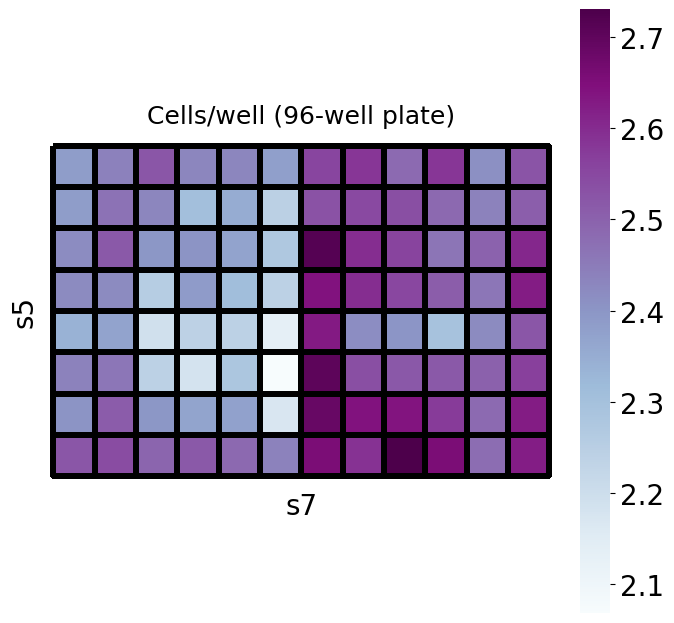

In [100]:
plot_df = s5s7_lb.pivot(index="row", columns="column", values="count")
plot_df = np.log10(plot_df)

# vmin=1.7708520116421442 #BY Value 
# vmax=3.494988973683168 #BY Value
vmax = plot_df.to_numpy().max()
vmin = plot_df.to_numpy().min()

#plot
heatmap = sns.heatmap(
    plot_df, 
    vmin=vmin,
    vmax=vmax,
    # annot=True, 
    cmap='BuPu',
    linewidth=3,
    linecolor='black',
    clip_on=False,
    square = True,
)

heatmap.set_title("Cells/well (96-well plate)", 
                  fontdict={'fontsize':18}, pad=16);

heatmap.set_xticklabels('')
heatmap.set_yticklabels('')
heatmap.set_xlabel('s7')
heatmap.set_ylabel('s5')

heatmap.tick_params(
    left=False, 
    bottom=False, 
    top = False
)

plt.savefig(
    fig_dir + '220109_PBMC_220527_79x79_loading_s5s7_legend.pdf',
            transparent=True,
            bbox_inches='tight',
            #facecolor = 'black'
)

plt.show()

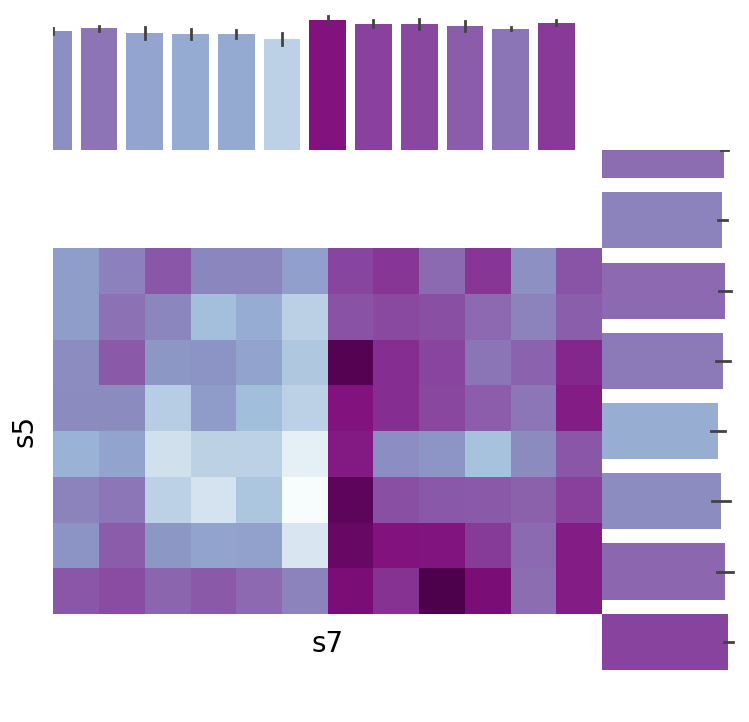

In [60]:
#make jointgrid
g = sns.JointGrid(
    height=8,
    ratio=4
)

# vmax = plot_df.to_numpy().max()
# vmin = plot_df.to_numpy().min()

# #reset row/column names for plotting
# df1 = df.copy()
# df1.columns = range(df1.columns.size)
# df1.reset_index(drop =True, inplace = True)
s5s7_lb['log_count'] = np.log10(s5s7_lb['count'])

#marg x
s5s7_lb.sort_values(by=['column'], inplace = True)

xplot = sns.barplot(  
    data=s5s7_lb,
    x=s5s7_lb['column'].astype(str), 
    y='log_count',
    color = 'grey',
    errorbar = 'sd',
    errwidth=2,
    capsize=0,
    # log = True,
    ax=g.ax_marg_x
)

#marg y
s5s7_lb.sort_values(by=['row'], inplace = True)

yplot = sns.barplot(  
    data=s5s7_lb,
    x='log_count',
    y=s5s7_lb['row'].astype(str),
    color = 'grey',
    errorbar = 'sd',
    errwidth=2,
    capsize=0,
    # log = True,
    ax=g.ax_marg_y
)

#main
heatmap = sns.heatmap(
    plot_df, 
    # vmin=1.7708520116421442, #BY Value 
    # vmax=3.494988973683168, #BY Value
    vmin=vmin,
    vmax = vmax,
    # annot=True, 
    cmap='BuPu',
    linecolor='black',
    clip_on=False,
    square = True,
    cbar = False,
    ax=g.ax_joint
)

#color bars
heights = np.array([bar.get_height() for bar in g.ax_marg_x.containers[0]])
divnorm = matplotlib.colors.TwoSlopeNorm(vmin=vmin, vcenter=(vmax+vmin)/2, vmax=vmax)
div_colors = plt.cm.BuPu(divnorm(heights))
for bar, color in zip(g.ax_marg_x.containers[0], div_colors):
    bar.set_facecolor(color)
    
widths = np.array([bar.get_width() for bar in g.ax_marg_y.containers[0]])
divnorm = matplotlib.colors.TwoSlopeNorm(vmin=vmin, vcenter=(vmax+vmin)/2, vmax=vmax)
div_colors = plt.cm.BuPu(divnorm(widths))
for bar, color in zip(g.ax_marg_y.containers[0], div_colors):
    bar.set_facecolor(color)

#remove labels
heatmap.tick_params(left=False, bottom=False, top = False)
g.ax_marg_x.tick_params(left=False, bottom=False, top = False)
g.ax_marg_y.tick_params(left=False, bottom=False, top = False)
sns.despine(bottom = True, left = True, right = True, top = True)

g.ax_joint.set_xticklabels('')
g.ax_joint.set_yticklabels('')

#label axes
g.ax_joint.set_xlabel('s7')
g.ax_joint.set_ylabel('s5')
plt.subplots_adjust(hspace=0, wspace=0)

#save
plt.savefig(
    fig_dir + '220109_PBMC_220527_79x79_loading_s5s7.pdf',
            transparent=True,
            bbox_inches='tight',
            #facecolor = 'black'
)

plt.show()

In [17]:
i5i7 = df_100.groupby(['i7','i5']).agg({'i5': ['count']}).reset_index()
i5i7.columns = ['i7','i5','count']

<AxesSubplot:xlabel='i5', ylabel='count'>

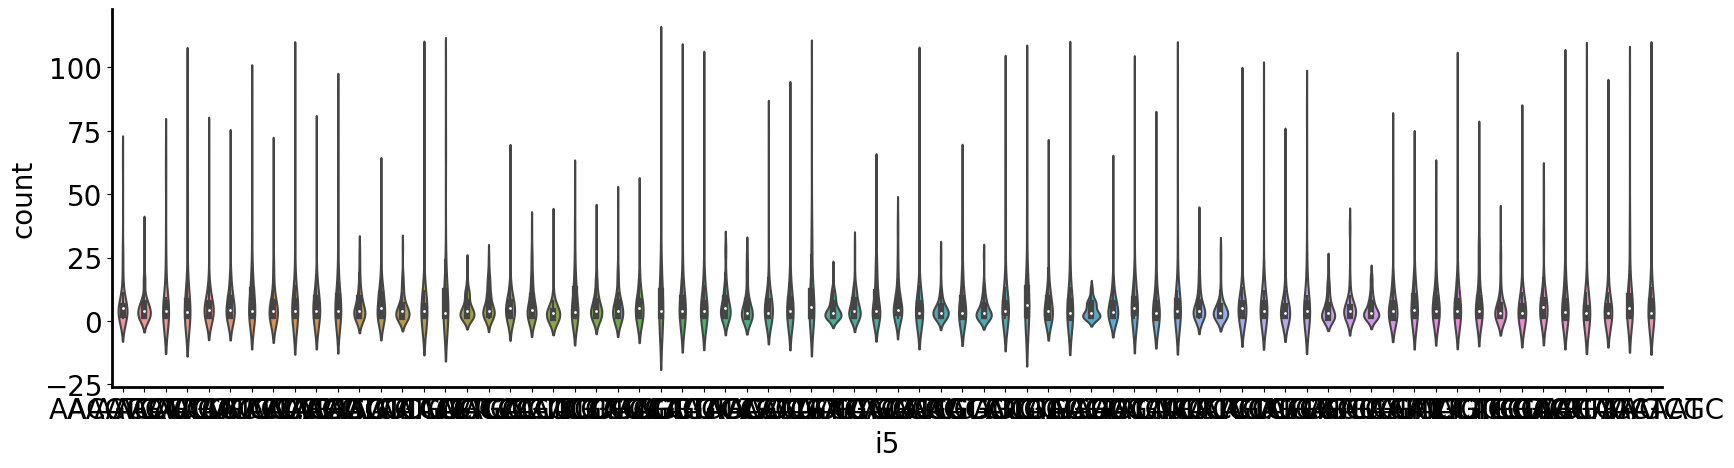

In [18]:
plt.figure(figsize=(20,5))
sns.violinplot(data=i5i7, x='i5', y='count')

[Text(0, 0, 'AAACGGTC'),
 Text(1, 0, 'AAATACAG'),
 Text(2, 0, 'AACGCCAT'),
 Text(3, 0, 'AAGAGGCA'),
 Text(4, 0, 'AATGGTAG'),
 Text(5, 0, 'AATTCGTT'),
 Text(6, 0, 'ACAAAGTG'),
 Text(7, 0, 'ACCGGCTA'),
 Text(8, 0, 'AGACCAGC'),
 Text(9, 0, 'AGGCAGAA'),
 Text(10, 0, 'AGGTTGGG'),
 Text(11, 0, 'AGTAGATT'),
 Text(12, 0, 'ATAAGTTA'),
 Text(13, 0, 'ATCACTCG'),
 Text(14, 0, 'ATGATGAT'),
 Text(15, 0, 'ATGGGAAC'),
 Text(16, 0, 'ATTGCCGG'),
 Text(17, 0, 'CAAGAATT'),
 Text(18, 0, 'CAATCTTA'),
 Text(19, 0, 'CAGAGAGG'),
 Text(20, 0, 'CATCCTGT'),
 Text(21, 0, 'CATCGACC'),
 Text(22, 0, 'CCAAATAA'),
 Text(23, 0, 'CCAACACG'),
 Text(24, 0, 'CCGTTTGT'),
 Text(25, 0, 'CCTCGCAG'),
 Text(26, 0, 'CGAGGCTG'),
 Text(27, 0, 'CGCGGACA'),
 Text(28, 0, 'CGGCCAAT'),
 Text(29, 0, 'CGGTTCCC'),
 Text(30, 0, 'CGTACTAG'),
 Text(31, 0, 'CTCATGGG'),
 Text(32, 0, 'CTCTCTAC'),
 Text(33, 0, 'CTTGGGTC'),
 Text(34, 0, 'GAAATGCC'),
 Text(35, 0, 'GACGCTCC'),
 Text(36, 0, 'GACTTAGT'),
 Text(37, 0, 'GAGCACGT'),
 Text(38, 0, 'GATCCAAA

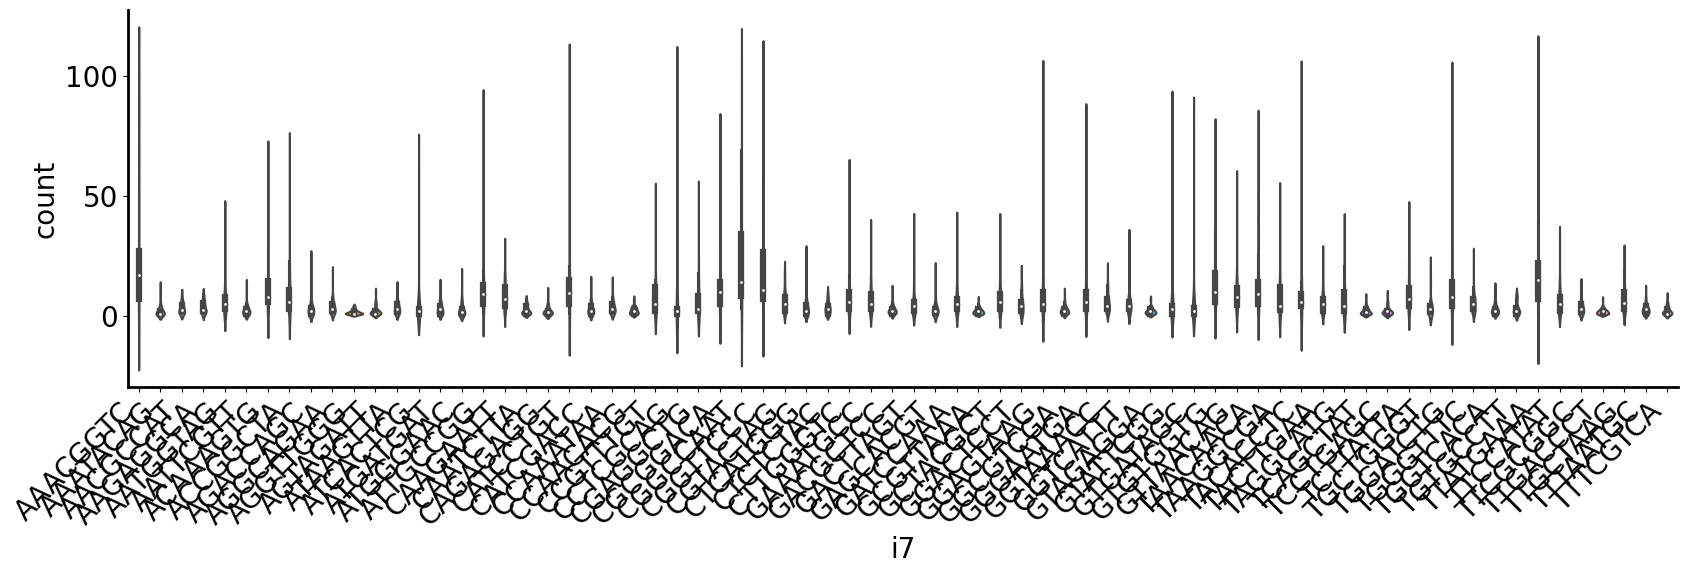

In [19]:
plt.figure(figsize=(20,5))
vio = sns.violinplot(data=i5i7, x='i7', y='count')
vio.set_xticklabels(
    vio.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',    
)

In [23]:
ann_dir = '/fh/fast/henikoff_s/user/jgreene/projects/sciCnT/data/barcodes/full_annotation_iCELL8_corrected.csv'
primer_annotation_file = pd.read_csv(ann_dir)
primer_annotation_file = primer_annotation_file.iloc[:,[2,3,0,1]]
primer_annotation_file.columns = ['i7', 'i5', 'row', 'column']
primer_annotation_file

,i7,i5,row,column
0,TAAGGCGA,GTAAGGAG,0,1
1,TAAGGCGA,TGGAAATC,0,2
2,TAAGGCGA,TTTCTAGC,0,3
3,TAAGGCGA,GCATTAAG,0,4
4,TAAGGCGA,CCAGTTTA,0,6
...,...,...,...,...
5179,GCGTTAAA,AGGTTGCC,67,45
5180,GCGTTAAA,TATTTGCG,67,50
5181,GCGTTAAA,TTTCTAGC,67,57
5182,GCGTTAAA,ATCGAATG,67,62


In [21]:
i5i7_lb = pd.merge(i5i7, primer_annotation_file, on=['i7','i5'])
i5i7_lb

,i7,i5,count,row,column
0,AAACGGTC,AACATGAT,5,43,56
1,AAACGGTC,AAGGAGTA,8,43,37
2,AAACGGTC,AATCTACA,22,43,51
3,AAACGGTC,ACATTCGT,63,43,64
4,AAACGGTC,ACCGGCCC,9,43,60
...,...,...,...,...,...
3880,TTTCGTCA,TGCATACT,1,31,29
3881,TTTCGTCA,TGGAAATC,4,31,56
3882,TTTCGTCA,TGGGCGGT,5,31,8
3883,TTTCGTCA,TTAACTTG,2,31,31


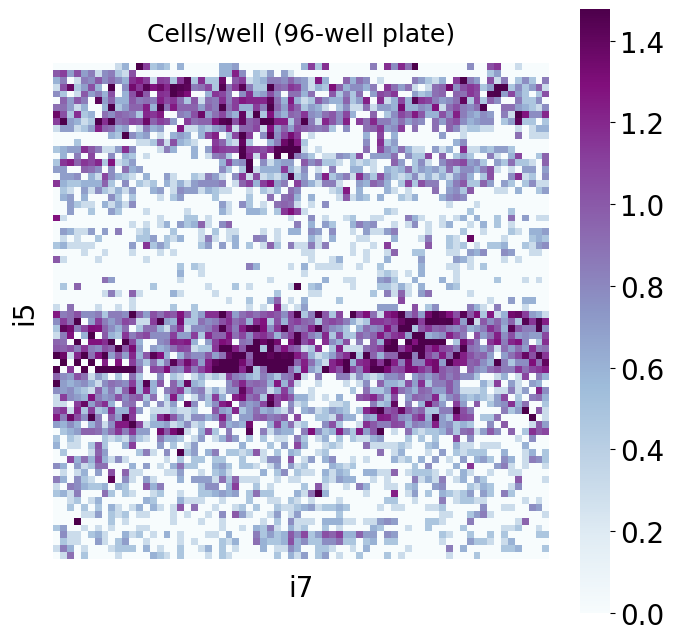

In [63]:
plot_df = i5i7_lb.pivot(index="row", columns="column", values="count")
plot_df = np.log10(plot_df)
plot_df.fillna(0, inplace = True)

# vmax = 1.9493900066449128 #BY value for comparison
vmax = np.log10(30)

#plot
heatmap = sns.heatmap(
    plot_df, 
    vmax=vmax, 
    # annot=True, 
    cmap='BuPu',
    # linewidth=3,
    # linecolor='black',
    clip_on=False,
    square = True
)

heatmap.set_title("Cells/well (96-well plate)", 
                  fontdict={'fontsize':18}, pad=16);

heatmap.set_xticklabels('')
heatmap.set_yticklabels('')

heatmap.set(
    xlabel='i7', 
    ylabel='i5'
)

heatmap.tick_params(
    left=False, 
    bottom=False, 
    top = False
)
plt.savefig(
    fig_dir + '220109_PBMC_220527_79x79_loading_i5i7_legend.pdf',
            transparent=True,
            bbox_inches='tight',
            #facecolor = 'black'
)

plt.show()

In [98]:
cpw40 = pd.concat([
    i5i7_lb[i5i7_lb['row'].isin(list(range(27, 36)))], 
    i5i7_lb[i5i7_lb['row'].isin(list(range(63, 72)))]
])
cpw40[cpw40["count"] != 0]["count"].mean()

2.619295958279009

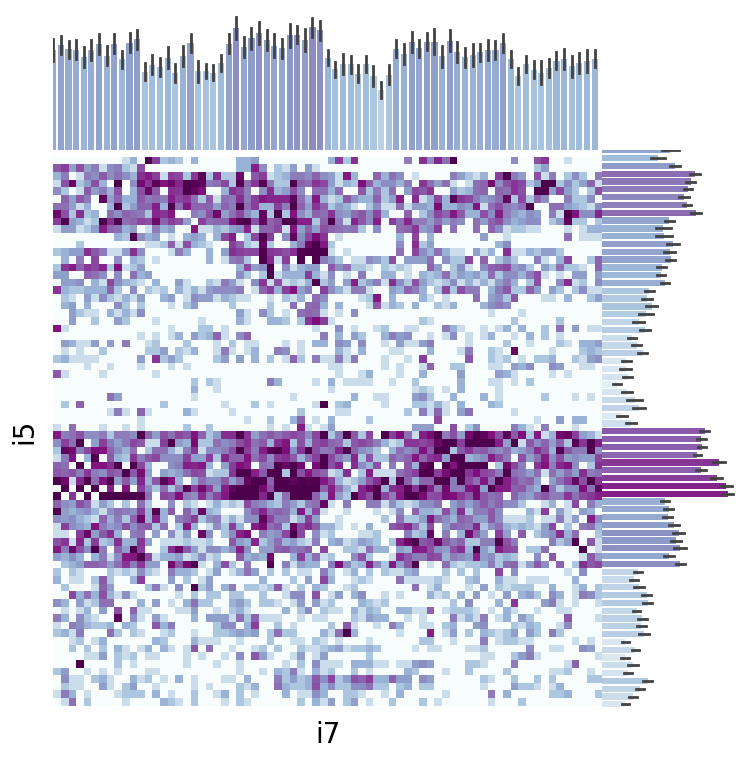

In [64]:
#make jointgrid
g = sns.JointGrid(
    height=8,
    ratio=4
)

# #reset row/column names for plotting
# df1 = df.copy()
# df1.columns = range(df1.columns.size)
# df1.reset_index(drop =True, inplace = True)
i5i7_lb['log_count'] = np.log10(i5i7_lb['count'])

#marg x
i5i7_lb.sort_values(by=['column'], inplace = True)

xplot = sns.barplot(  
    data=i5i7_lb,
    x=i5i7_lb['column'].astype(str), 
    y='log_count',
    color = 'grey',
    errwidth=2,
    errorbar = 'se',
    capsize=0,
    # log = True,
    ax=g.ax_marg_x
)

#marg y
i5i7_lb.sort_values(by=['row'], inplace = True)

yplot = sns.barplot(  
    data=i5i7_lb,
    x='log_count',
    y=i5i7_lb['row'].astype(str),
    color = 'grey',
    errwidth=2,
    errorbar = 'se',
    capsize=0,
    # log = True,
    ax=g.ax_marg_y
)

#main
heatmap = sns.heatmap(
    plot_df, 
    vmin=0, 
    vmax=vmax, 
    # annot=True, 
    cmap='BuPu',
    # linewidth=3,
    # linecolor='black',
    # clip_on=False,
    square = True,
    cbar = False,
    ax=g.ax_joint
)

#color bars
heights = np.array( [bar.get_height() for bar in g.ax_marg_x.containers[0]])
divnorm = matplotlib.colors.TwoSlopeNorm(vmin=0, vcenter=vmax/2, vmax=vmax)
div_colors = plt.cm.BuPu(divnorm(heights))
for bar, color in zip(g.ax_marg_x.containers[0], div_colors):
    bar.set_facecolor(color)
    
widths = np.array( [bar.get_width() for bar in g.ax_marg_y.containers[0]])
divnorm = matplotlib.colors.TwoSlopeNorm(vmin=0, vcenter=vmax/2, vmax=vmax)
div_colors = plt.cm.BuPu(divnorm(widths))
for bar, color in zip(g.ax_marg_y.containers[0], div_colors):
    bar.set_facecolor(color)

#remove labels
heatmap.tick_params(left=False, bottom=False, top = False)
g.ax_marg_x.tick_params(left=False, bottom=False, top = False)
g.ax_marg_y.tick_params(left=False, bottom=False, top = False)
sns.despine(bottom = True, left = True, right = True, top = True)

g.ax_joint.set_xticklabels('')
g.ax_joint.set_yticklabels('')

#label axes
g.ax_joint.set_xlabel('i7')
g.ax_joint.set_ylabel('i5')
plt.subplots_adjust(hspace=0, wspace=0)

#save
plt.savefig(
    fig_dir + '220109_PBMC_220527_79x79_loading_i5i7.pdf',
            transparent=True,
            bbox_inches='tight',
            #facecolor = 'black'
)

plt.show()